In [1]:
import torch
from torch.autograd import Function, Variable
import torch.nn.functional as F
from torch import nn
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.nn.utils import parameters_to_vector
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import numpy.random as npr

import matplotlib
from matplotlib import pyplot as plt

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost, LinDx
from mpc import casadi_control
#from mpc.dynamics import NNDynamics
#import mpc.util as eutil
from mpc.env_dx import frenet_dyn_bicycle, frenet_kin_bicycle  #changed
from mpc.track.src import simple_track_generator, track_functions

import time
import os
import shutil
import pickle as pkl
import collections

import argparse

from time import time

In [2]:
# Parameters

device = 'cpu' #to do
k_curve = 100.

mpc_T = 25
H_curve = 75

n_batch = 32

l_r = 0.2
l_f = 0.2

v_max = 2.5
a_max = 3.
delta_max = 0.6

dt = 0.04

# not using
ac_max = (0.7*v_max)**2 * delta_max / (l_r+l_f)

In [3]:
class NN(nn.Module):
    #changed output dimensions
    def __init__(self, H, S, O):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(H + S, 512)  
        self.fc2 = nn.Linear(512, 256)  
        self.output1 = nn.Linear(256, O) 
        self.output2 = nn.Linear(256, O) 

    def forward(self, c, x0):
        combined = torch.cat((c, x0), dim=1)
        x = F.relu(self.fc1(combined))
        x = F.relu(self.fc2(x))
        q = F.relu(self.output1(x)) + 0.0001
        p = self.output2(x)
        return q, p
        

def sample_xinit(n_batch):
    def uniform(shape, low, high):
        r = high-low
        return torch.rand(shape)*r+low
    sigma = uniform(n_batch, 0.01, 20.)
    d = uniform(n_batch, -track_width*0.35, track_width*0.35)
    phi = uniform(n_batch, -0.4*np.pi, 0.4*np.pi)
    v = uniform(n_batch, .01, 0.95*v_max)

    sigma_0 = sigma
    sigma_diff = sigma-sigma_0
    
    d_pen = penalty_d(d, 0.35*track_width)
    v_ub = penalty_v(v, v_max)
    
    k = true_dx.curv(sigma)

    xinit = torch.stack((sigma, d, phi, v, sigma_0, sigma_diff, d_pen, v_ub), dim=1)
    return xinit


def sample_xinit_paj(n_batch):
    def uniform(shape, low, high):
        r = high-low
        return torch.rand(shape)*r+low
    sigma = uniform(n_batch, 0.01, 20.)
    d = uniform(n_batch, -track_width*0.4, track_width*0.4)
    phi = uniform(n_batch, -0.4*np.pi, 0.4*np.pi)
    r = uniform(n_batch, -0.05*np.pi, 0.05*np.pi)
    v_x = uniform(n_batch, 1., v_max)
    v_y = uniform(n_batch, 0., 0.05)

    sigma_0 = sigma
    sigma_diff = sigma-sigma_0
    
    d_pen = penalty_d(d, 0.25*track_width)
    v_ub = penalty_v(v_x, v_max)
    
    k = true_dx.curv(sigma)

    xinit = torch.stack((sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub), dim=1)
    return xinit
        #x_init_train = x_init_sim[:,[0,1,2,4,6,7,8,9]]

    
def penalty_d(d, th, factor=10000):  
    overshoot_pos = (d - th).clamp(min=0)
    overshoot_neg = (-d - th).clamp(min=0)
    penalty_pos = torch.exp(overshoot_pos) - 1
    penalty_neg = torch.exp(overshoot_neg) - 1 
    return factor*(penalty_pos + penalty_neg)


def penalty_v(v, th, factor=10000): 
    overshoot_pos = (v - th).clamp(min=0)
    overshoot_neg = (-v + 0.001).clamp(min=0)
    penalty_pos = torch.exp(overshoot_pos) - 1
    penalty_neg = torch.exp(overshoot_neg) - 1 
    return factor*(penalty_pos + penalty_neg)


def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
  
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])


def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])


def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)    
    return torch.tensor([x, y])


def get_loss_progress(x_init, dx, _Q, _p, mpc_T=mpc_T):    
        
        pred_x, pred_u, pred_objs = mpc.MPC(
            dx.n_state, dx.n_ctrl, mpc_T,
            u_lower=u_lower, u_upper=u_upper, u_init=u_init,
            lqr_iter=lqr_iter,
            verbose=1,
            exit_unconverged=False,
            detach_unconverged=False,
            linesearch_decay=.8,
            max_linesearch_iter=10,
            grad_method=grad_method,
            eps=eps,
            n_batch=n_batch,
        )(x_init, QuadCost(_Q, _p), dx)        
        progress_loss = torch.mean(-pred_x[mpc_T-1,:,0] + pred_x[0,:,0])                    
        return progress_loss
    
    
    
def get_loss_progress_new(x_init_train, x_init_sim, 
                          dx, dx_sim, 
                          _Q, _p, 
                          mpc_T=mpc_T, 
                          H_curve=H_curve):    
               
        assert H_curve%mpc_T == 0
        
        x_curr_sim = x_init_sim
        x_curr_train = x_init_train
        
        for s in range(H_curve//mpc_T):
                    
            pred_x, pred_u, pred_objs = mpc.MPC(
                dx.n_state, dx.n_ctrl, mpc_T,
                u_lower=u_lower, u_upper=u_upper, u_init=u_init,
                lqr_iter=lqr_iter,
                verbose=0,
                exit_unconverged=False,
                detach_unconverged=False,
                linesearch_decay=.4,
                max_linesearch_iter=4,
                grad_method=grad_method,
                eps=eps,
                n_batch=n_batch,
            )(x_curr_train, QuadCost(_Q, _p), dx)
            
            for ss in range(mpc_T):
                x_curr_sim_ = x_curr_sim.clone()
                x_curr_sim = true_sim_dx.forward(x_curr_sim_, pred_u[ss])

            x_curr_train = x_curr_sim
            x_curr_train[:,4] = x_curr_train[:,0]
            x_curr_train[:,5] = 0.
        
        progress_loss = torch.mean(-x_curr_train[:,0] + x_init_train[:,0])
         
        # Below is to check if negative sigma isbeing outputted    
        #mask_weird = x_curr_train[:,0]<x_init_train[:,0]
        #print(x_init_train[mask_weird].shape)
            
            
        d_loss = torch.mean(x_curr_train[:,1]**2)
            
        return progress_loss, d_loss
       
    
def get_curve_hor_from_x(x, track_coord, H_curve):
    idx_track_batch = ((x[:,0]-track_coord[[2],:].T)**2).argmin(0)
    idcs_track_batch = idx_track_batch[:, None] + torch.arange(H_curve)
    curvs = track_coord[4,idcs_track_batch].float()
    return curvs


def cost_to_batch_NN(q, p, n_batch, mpc_T):
    Q_batch = torch.zeros(n_batch, q.shape[1], q.shape[1])
    rows, cols = torch.arange(q.shape[1]), torch.arange(q.shape[1])  
    Q_batch[:, rows, cols] = q 
    Q_batch = Q_batch.unsqueeze(0).repeat(
                mpc_T, 1, 1, 1)    
    p_batch = p.unsqueeze(0).repeat(mpc_T, 1, 1)
    return Q_batch, p_batch


def cost_to_batch(q, p, n_batch, mpc_T):
    Q_batch = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
                mpc_T, n_batch, 1, 1
            )
    p_batch = p.unsqueeze(0).repeat(mpc_T, n_batch, 1)   
    return Q_batch, p_batch

def bound_params(q, p):
    q[:,1] = q[:,1] + 10.0
    #q = q + 1.
    q[:,0] = 0.00001
    q[:,4] = 0.00001
    q = q.clip(0.00001, 40.)
    p[:,0] = 0.0
    p[:,1] = 0.0
    p[:,2] = 0.0
    p[:,4] = 0.0
    p2 = p.clone()
    p2 = p.clip(-200.,200.)
    q2 = q.clone()
    return q2, p2


def bound_params_paj(q, p):
    q[:,1] = q[:,1] + 10.0
    #q = q + 1.
    q[:,0] = 0.00001
    q[:,6] = 0.00001
    q = q.clip(0.00001, 40.)
    p[:,0] = 0.0
    p[:,1] = 0.0
    p[:,2] = 0.0
    p[:,6] = 0.0
    p2 = p.clone()
    p2 = p.clip(-200.,200.)
    q2 = q.clone()
    return q2, p2


def inference_params(x_in, track_coord, H_curve, model, q_pen, p_pen, N, mpc_T):
    curvs = get_curve_hor_from_x(x_in, track_coord, H_curve)
    q, p = model(curvs, x_in[:,1:4])
    q = torch.cat((q[:,:6], q_pen, q[:,6:]), dim=1)
    p = torch.cat((p[:,:6], p_pen, p[:,6:]), dim=1)
    q2, p2 = bound_params(q, p) 
    Q_batch, p_batch = cost_to_batch_NN(q2, p2, N, mpc_T)
    return Q_batch, p_batch


def inference_params_paj(x_in, track_coord, H_curve, model, q_pen, p_pen, N, mpc_T):
    curvs = get_curve_hor_from_x(x_in, track_coord, H_curve)
    q, p = model(curvs, x_in[:,1:6])
    q = torch.cat((q[:,:8], q_pen, q[:,8:]), dim=1)
    p = torch.cat((p[:,:8], p_pen, p[:,8:]), dim=1)
    q2, p2 = bound_params(q, p) 
    Q_batch, p_batch = cost_to_batch_NN(q2, p2, N, mpc_T)
    return Q_batch, p_batch

In [4]:
# Let's try to create a track 
track_density = 300
track_width = 0.5

gen = simple_track_generator.trackGenerator(track_density,track_width)
track_name = 'LONG_TRACK'

t = 0.3
init = [0,0,0]

track_function = {
    'DEMO_TRACK'    : track_functions.demo_track,
    'HARD_TRACK'    : track_functions.hard_track,
    'LONG_TRACK'    : track_functions.long_track,
    'LUCERNE_TRACK' : track_functions.lucerne_track,
    'BERN_TRACK'    : track_functions.bern_track,
    'INFINITY_TRACK': track_functions.infinity_track,
    'SNAIL_TRACK'   : track_functions.snail_track
}.get(track_name, track_functions.demo_track)
    
track_function(gen, t, init)
    
gen.populatePointsAndArcLength()
gen.centerTrack()

track_coord = torch.from_numpy(np.vstack([gen.xCoords, gen.yCoords, gen.arcLength, gen.tangentAngle, gen.curvature]))

In [5]:
params = torch.tensor([l_r, l_f, track_width, v_max, ac_max, dt, a_max, delta_max, k_curve])

true_dx = frenet_kin_bicycle.FrenetKinBicycleDx(track_coord, params, 'cpu')
true_sim_dx = frenet_kin_bicycle.FrenetKinBicycleDx(track_coord, params, 'cpu')
#true_sim_dx = frenet_dyn_bicycle.FrenetDynBicycleDx(track_coord, params)

u_lower = torch.tensor([-a_max, -delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_upper = torch.tensor([a_max, delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)

n_state = true_dx.n_state
n_ctrl = true_dx.n_ctrl

eps = .1
lqr_iter = 30
grad_method = GradMethods.AUTO_DIFF

8
8


In [6]:
env_params = true_dx.params
env_params_sim = true_sim_dx.params

track_coord = track_coord.to(device)

dx = true_dx.__class__(track_coord,env_params,device)
dx_sim = true_sim_dx.__class__(track_coord,env_params_sim,device)

q_penalty = .0001*torch.ones(2).to(device)
p_penalty = torch.ones(2).to(device)

model = NN(H_curve, 3, 8)
#model.load_state_dict(torch.load('model.pkl'))
opt = optim.RMSprop(model.parameters(), lr=5e-4)
q_penalty_batch = q_penalty.unsqueeze(0).repeat(n_batch,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(n_batch,1)

8
8


In [7]:
for i in range(500):
    
    start_time = time()
    
    x_init_sim = sample_xinit(n_batch).to(device)
    
    #x_init_train = x_init_sim[:,[0,1,2,4,6,7,8,9]]
    x_init_train = x_init_sim
    
    Q_batch, p_batch = inference_params(
        x_init_train, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        n_batch, mpc_T)
           
    progress_loss, d_loss = get_loss_progress_new(x_init_train, x_init_sim, 
                                      dx, dx_sim, 
                                      Q_batch, p_batch)
    
    total_loss = progress_loss
    
    opt.zero_grad()
    total_loss.backward()
    opt.step()
    
    end_time = time()
    
    print(f'Batch: {i} , Prog. with (mpc_T, H_curve) = ({mpc_T} , {H_curve}): ', 
          -round(progress_loss.item(), 4),
          '\t Time: ', round(end_time-start_time, 4)
         )
    
    # It would be nice to add a validation step here 

/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/torch/autograd/__init__.py:411: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/torch/_tensor.py:770: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch

[WARNING] pnqp warning: Did not converge
Batch: 0 , Prog. with (mpc_T, H_curve) = (18 , 36):  1.9807 	 Time:  7.7365
Batch: 1 , Prog. with (mpc_T, H_curve) = (18 , 36):  2.6522 	 Time:  7.9935
[WARNING] pnqp warning: Did not converge
Batch: 2 , Prog. with (mpc_T, H_curve) = (18 , 36):  1.9587 	 Time:  10.9804
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 3 , Prog. with (mpc_T, H_curve) = (18 , 36):  1.9221 	 Time:  10.3994
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 4 , Prog. with (mpc_T, H_curve) = (18 , 36):  2.1918 	 Time:  11.3008
[WARNING] pnqp warning: Did not converge
Batch: 5 , Prog. with (mpc_T, H_curve) = (18 , 36):  1.5857 	 Time:  11.114
[WARNING] pnqp warning: Did not converge
Batch: 6 , Prog. with (mpc_T, H_curve) = (18 , 36):  2.679 	 Time:  10.9177
Batch: 7 , Prog. with (mpc_T, H_curve) = (18 , 36):  1.9512 	 Time:  10.3029
Batch: 8 , Prog. with (mpc_T, H_curve) = (18 , 36):  1.4075 

KeyboardInterrupt: 

In [8]:
torch.save(model.state_dict(), 'model.pkl')

In [10]:
model = NN(H_curve, 3, 8)
model.load_state_dict(torch.load('./models/model_349.pkl'))

<All keys matched successfully>

In [11]:
N_test = 1
mpc_T_test = mpc_T

# Below you can put any initial state you want (any that make sense)
sigma = torch.tensor(0.01)
d = torch.tensor(0.05)
d_pen = penalty_d(d, 0.35*track_width)
r = torch.tensor(0.0)
v_x = torch.tensor(0.5) #make sure this is never 0
v_ub = penalty_v(v_x, v_max*0.95)
v_y = torch.tensor(0.0)  # this can be zero
sigma_0 = sigma
sigma_diff = sigma-sigma_0

x_init_exec_sim = torch.tensor([sigma, d, -.0, r, v_x, v_y, sigma_0, 
                             sigma_diff, d_pen, v_ub])

In [12]:
# Added here the bounds of U
u_lower_test = torch.tensor([-a_max, -delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_upper_test = torch.tensor([a_max, delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)

In [13]:
N_sim_total = 150

x_execution = torch.zeros((N_sim_total,1,8))
x_simulated = torch.zeros((N_sim_total,1,8))

x_simulated[0] = x_init_exec_sim[[0,1,2,4,6,7,8,9]]
x_execution[0] = x_init_exec_sim[[0,1,2,4,6,7,8,9]]
#x_execution[0] = x_init_exec_sim[[0,1,2,4,6,7,8,9]]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

u_exec = torch.zeros((N_sim_total, 2))

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    x_exe = x_execution[i-1]
    print('It:', i, 'x=', x_sim.detach().numpy().round(3))

    Q_test_batch, p_test_batch = inference_params(
        x_sim, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)
    
    print('Q: ', Q_test_batch[0,0].diag().detach().numpy().round(2), '\n p: ', 
          p_test_batch[0,0].detach().numpy().round(2))

    x_mpc_test, u_mpc_test, objs_mpc_test = mpc.MPC(
                n_state, n_ctrl, mpc_T_test,
                u_lower=u_lower_test, u_upper=u_upper_test, u_init=u_init,
                lqr_iter=30,
                verbose=0,
                exit_unconverged=False,
                detach_unconverged=True,
                linesearch_decay=.8,
                max_linesearch_iter=10,
                grad_method=grad_method,
                eps=.1,
                n_batch=N_test,
            )(x_exe, QuadCost(Q_test_batch, p_test_batch), dx)

    x_sim = true_sim_dx.forward(x_exe, u_mpc_test[0])
    
    u_exec[i] = u_mpc_test[0]
    
    x_execution[i] = x_mpc_test[1]
    x_execution[i,0,4] = x_execution[i,0,0]
    x_execution[i,0,5] = 0.
    
    x_simulated[i] = x_sim
    x_simulated[i,0,4] = x_sim[0,0]
    x_simulated[i,0,5] = 0.

It: 1 x= [[ 0.01  0.05 -0.    0.5   0.01  0.    0.    0.  ]]
Q:  [ 0.   10.    0.    0.    0.    0.05  0.    0.    0.05  0.  ] 
 p:  [ 0.    0.    0.   -0.03  0.   -0.01  1.    1.   -0.08 -0.04]


AssertionError: 

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


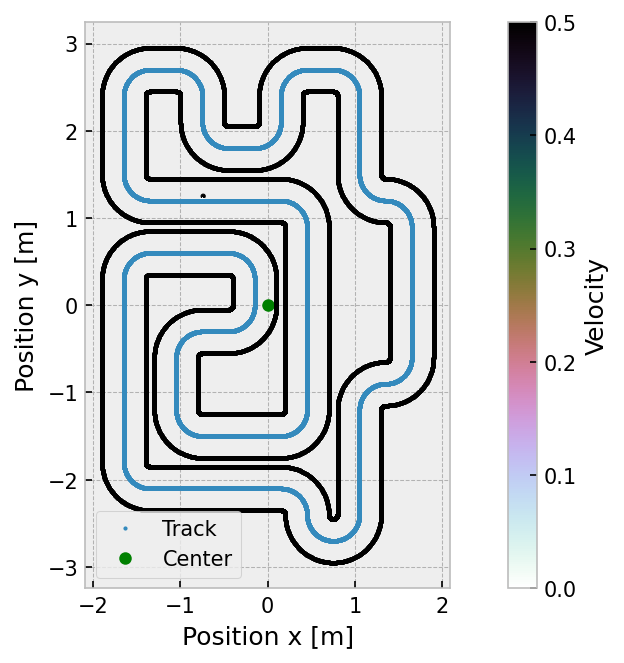

In [51]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

x_plot = np.array(x_list)
y_plot = np.array(y_list)

from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,3].detach(), cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


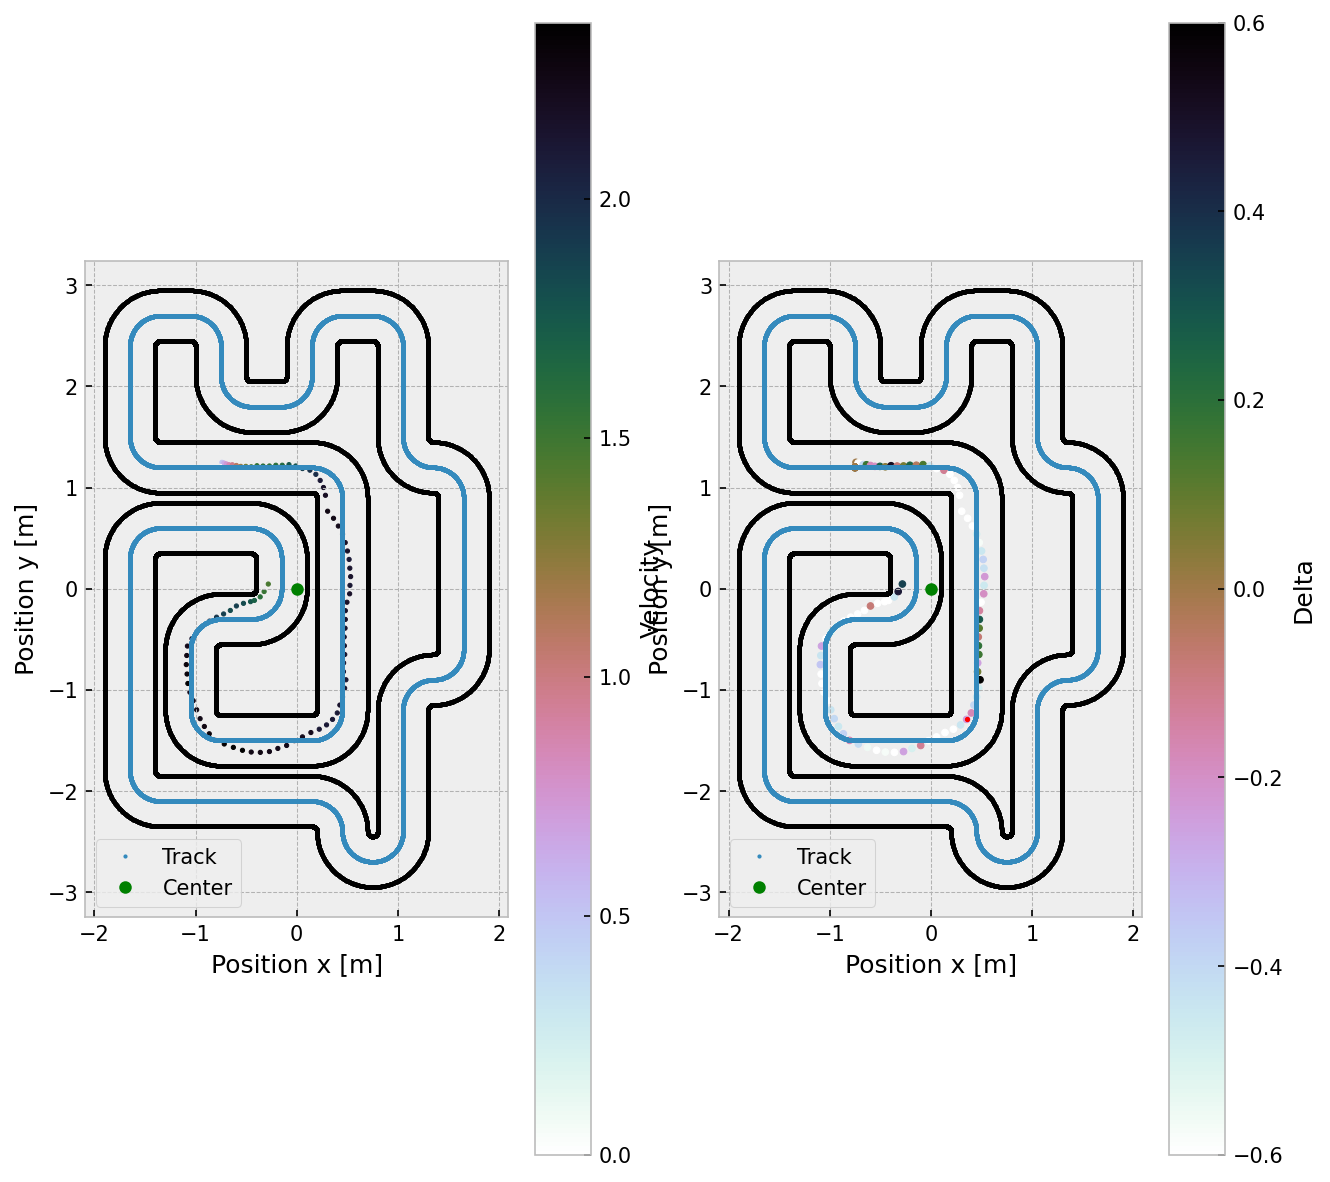

In [14]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

x_plot = np.array(x_list)
y_plot = np.array(y_list)

from matplotlib import cm

fig, axs = plt.subplots(1,2, figsize=(10,10), dpi=150)
gen.plotPoints(axs[0])
custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = axs[0].scatter(x_plot, y_plot, c=x_simulated[:,0,3].detach().numpy(), cmap=custom_cmap, s=4)
cbar1 = plt.colorbar(sct)
cbar1.set_label('Velocity') 

gen.plotPoints(axs[1])
custom_cmap2 = plt.get_cmap('cubehelix').reversed()
sct2 = axs[1].scatter(x_plot, y_plot, c=u_exec[:,1].detach().numpy(), cmap=custom_cmap2, s=10)
cbar2 = plt.colorbar(sct2)
cbar2.set_label('Delta') 

axs[1].scatter(x_plot[47], y_plot[47], c='red', s=4)

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

In [18]:
model = NN(H_curve, 3, 8)
model.load_state_dict(torch.load('./models/model_799.pkl'))

<All keys matched successfully>

In [19]:
from mpc import casadi_control
from importlib import reload
reload(casadi_control)

<module 'mpc.casadi_control' from '/home/alan/Desktop/Research/Code/race_application/mpc/casadi_control.py'>

In [ ]:
mpc_T_test = mpc_T

control = casadi_control.CasadiControl(track_coord, params.numpy(), k_curve)

dc = 2 #number constraints
df = 2 #number of states we artificially added like sigma_0, sigma_diff
dx = n_state #number states taken from the dynamics (including penalties and sigma_o/sigma_diff)
du = n_ctrl #number control inputs

N_sim_total = 200
#x_simulated = torch.zeros((N_sim_total,1,10))

#x_simulated[0] = x_init_test[0]

x_execution = np.zeros((N_sim_total,1,8))
x_simulated = np.zeros((N_sim_total,1,8))

x_simulated[0] = x_init_exec_sim[[0,1,2,4,6,7,8,9]].numpy()
x_execution[0] = x_init_exec_sim[[0,1,2,4,6,7,8,9]].numpy()

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

u_exec = np.zeros((N_sim_total, 2))

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.round(3))

    Q_test_batch, p_test_batch = inference_params(
        torch.tensor(x_sim).float(), track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)
    
    test_q = torch.diag(Q_test_batch[0,0]).detach().numpy()
    test_p = p_test_batch[0,0].detach().numpy()
    
    #sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub 
    
    #test_q=np.array([0.,1.5,0.2,0.01,0.0,0.,0.,0.0,0.,0.,0.1,0.1])
    #test_p=np.array([0.,0.,0.,0.,-1.,0.,0.,-4.5,100.,100., 0., 0.])

    sol = control.mpc_casadi_with_constraints(
        test_q,test_p,x_sim,
        mpc_T_test,df,dc,dx,du)
    
    u_mpc_test = sol[-du*mpc_T_test:]
    x_mpc_test = sol[:-du*mpc_T_test]
    u_mpc_test = u_mpc_test.reshape(mpc_T_test,du)
    x_mpc_test = x_mpc_test.reshape(mpc_T_test+1,dx-dc-df)

    x_sim = true_sim_dx.forward(torch.tensor(x_sim[0]), torch.tensor(u_mpc_test[0])).numpy()
        
    u_exec[i] = u_mpc_test[0]

    x_simulated[i,0,:4] = torch.tensor(x_sim[0,:4])
    x_simulated[i,0,4] = torch.tensor(x_sim[0,0])
    x_simulated[i,0,5] = 0.
    

    #x_simulated[i,0,:4] = torch.tensor(x_mpc_test[1])
    #x_simulated[i,0,4] = torch.tensor(x_simulated[i,0,0])
    #x_simulated[i,0,5] = 0.

9
It: 1 x= [[ 0.01  0.05 -0.    0.5   0.01  0.    0.    0.  ]]
It: 2 x= [[ 0.029  0.044 -0.032  0.499  0.029  0.     0.     0.   ]]
It: 3 x= [[ 0.048  0.036 -0.065  0.496  0.048  0.     0.     0.   ]]
It: 4 x= [[ 0.066  0.029 -0.097  0.492  0.066  0.     0.     0.   ]]
It: 5 x= [[ 0.084  0.021 -0.129  0.486  0.084  0.     0.     0.   ]]
It: 6 x= [[ 0.101  0.012 -0.16   0.478  0.101  0.     0.     0.   ]]
It: 7 x= [[ 0.118  0.003 -0.191  0.469  0.118  0.     0.     0.   ]]
It: 8 x= [[ 0.134 -0.006 -0.221  0.458  0.134  0.     0.     0.   ]]
It: 9 x= [[ 0.15  -0.016 -0.251  0.446  0.15   0.     0.     0.   ]]
It: 10 x= [[ 0.168 -0.018 -0.24   0.433  0.168  0.     0.     0.   ]]
It: 11 x= [[ 0.185 -0.02  -0.228  0.419  0.185  0.     0.     0.   ]]
It: 12 x= [[ 0.202 -0.021 -0.216  0.405  0.202  0.     0.     0.   ]]
It: 13 x= [[ 0.218 -0.022 -0.204  0.391  0.218  0.     0.     0.   ]]
It: 14 x= [[ 0.233 -0.023 -0.192  0.376  0.233  0.     0.     0.   ]]
It: 15 x= [[ 0.248 -0.023 -0.179  0

It: 121 x= [[0.385 0.    0.01  0.004 0.385 0.    0.    0.   ]]
It: 122 x= [[0.385 0.    0.01  0.004 0.385 0.    0.    0.   ]]
It: 123 x= [[0.386 0.    0.011 0.004 0.386 0.    0.    0.   ]]
It: 124 x= [[0.386 0.    0.011 0.004 0.386 0.    0.    0.   ]]
It: 125 x= [[0.386 0.    0.011 0.003 0.386 0.    0.    0.   ]]
It: 126 x= [[0.386 0.001 0.011 0.003 0.386 0.    0.    0.   ]]
It: 127 x= [[0.386 0.001 0.012 0.003 0.386 0.    0.    0.   ]]
It: 128 x= [[0.386 0.001 0.012 0.003 0.386 0.    0.    0.   ]]
It: 129 x= [[0.386 0.001 0.012 0.003 0.386 0.    0.    0.   ]]
It: 130 x= [[0.386 0.001 0.012 0.003 0.386 0.    0.    0.   ]]
It: 131 x= [[0.387 0.001 0.012 0.003 0.387 0.    0.    0.   ]]
It: 132 x= [[0.387 0.001 0.012 0.002 0.387 0.    0.    0.   ]]


In [ ]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

x_plot = np.array(x_list)
y_plot = np.array(y_list)

from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,3], cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 
#ax.plot(x_plot, y_plot)

#ax.scatter(x_plot[23:25], y_plot[23:25], color='red', s=4)

#ax.scatter(x_plot, y_plot, s=4, color='red')

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

In [17]:
mpc_T

20

In [20]:
params

tensor([0.2000, 0.2000, 0.5000, 2.5000, 3.0625, 0.0400, 3.0000, 0.4000])

In [9]:
n_ctrl

2

In [214]:
from mpc import casadi_control
from importlib import reload
reload(casadi_control)

<module 'mpc.casadi_control' from '/home/alan/Desktop/Research/Code/race_application/mpc/casadi_control.py'>

In [215]:
N_test = 1
mpc_T_test = mpc_T

# Below you can put any initial state you want (any that make sense)
sigma = torch.tensor(0.01)
d = torch.tensor(0.05)
d_pen = penalty_d(d, 0.30*track_width)
r = torch.tensor(0.0)
v_x = torch.tensor(0.30) #make sure this is never 0
v_ub = penalty_v(v_x, v_max)
v_y = torch.tensor(0.0)  # this can be zero
sigma_0 = sigma
sigma_diff = sigma-sigma_0

x_init_exec_sim = torch.tensor([sigma, d, -.0, r, v_x, v_y, sigma_0, 
                             sigma_diff, d_pen, v_ub])

In [216]:
curve_approx = 200
true_sim_dx.smooth_curve = curve_approx

In [217]:
mpc_T_test = 52

#x_warmstart = np.zeros((n_state+n_ctrl-2,mpc_T_test+1))
#x_warmstart[:] = np.array([[1.5, 0., 0., 0.5, 0., 0., 0.1, 0.0]]).T

control = casadi_control.CasadiControl(track_coord, params.numpy(), curve_approx)

dc = 2 #number constraints
df = 2 #number of states we artificially added like sigma_0, sigma_diff
dx = n_state #number states taken from the dynamics (including penalties and sigma_o/sigma_diff)
du = n_ctrl #number control inputs

N_sim_total = 250
#x_simulated = torch.zeros((N_sim_total,1,10))

#x_simulated[0] = x_init_test[0]

x_execution = np.zeros((N_sim_total,1,8))
x_simulated = np.zeros((N_sim_total,1,8))

x_simulated[0] = x_init_exec_sim[[0,1,2,4,6,7,8,9]].numpy()
x_execution[0] = x_init_exec_sim[[0,1,2,4,6,7,8,9]].numpy()

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

u_exec = np.zeros((N_sim_total, 2))

x_sim = x_simulated[0]

for i in range(1,N_sim_total):
   
    print('It:', i, 'x=', x_sim.round(3))

    Q_test_batch, p_test_batch = inference_params(
        torch.tensor(x_sim).float(), track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)
    
    test_q = torch.diag(Q_test_batch[0,0]).detach().numpy()
    test_p = p_test_batch[0,0].detach().numpy()
    
    #sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub 
    
    test_q=np.array([0., 1.5, 0.2, 0., 0., 0., 0., 0., 0.1, 0.1])
    test_p=np.array([0., 0., 0., -1., 0., -2.5, 50., 50., 0., 0.])

    sol = control.mpc_casadi_with_constraints(
        test_q,test_p,x_sim,
        mpc_T_test,df,dc,dx,du, x_warmstart)
    
    u_mpc_test = sol[-du*mpc_T_test:]
    
    
    
    x_mpc_test = sol[:-du*mpc_T_test]
    
    u_mpc_test = u_mpc_test.reshape(mpc_T_test,du)
    x_mpc_test = x_mpc_test.reshape(mpc_T_test+1,dx-dc-df)

    print(u_mpc_test[0])
    #import pdb
    #pdb.set_trace()
    
    x_sim = true_sim_dx.forward(torch.tensor(x_sim[0]), torch.tensor(u_mpc_test[0])).numpy()
        
    u_exec[i] = u_mpc_test[0]

    x_simulated[i,0,:4] = torch.tensor(x_sim[0,:4])
    x_simulated[i,0,4] = torch.tensor(x_sim[0,0])
    x_simulated[i,0,5] = 0.

9
It: 1 x= [[ 0.01  0.05 -0.    0.3   0.01  0.    0.    0.  ]]
[3.00000003 0.09768849]
It: 2 x= [[0.022 0.051 0.003 0.42  0.01  0.012 0.    0.   ]]
[3.00000003 0.14768177]
It: 3 x= [[0.039 0.052 0.009 0.54  0.01  0.029 0.    0.   ]]
[3.00000003 0.10556062]
It: 4 x= [[0.06  0.053 0.015 0.66  0.01  0.05  0.    0.   ]]
[3.00000002 0.21267989]
It: 5 x= [[0.086 0.056 0.029 0.78  0.01  0.076 0.    0.   ]]
[ 3.00000003 -0.09407769]
It: 6 x= [[0.118 0.056 0.022 0.9   0.01  0.108 0.    0.   ]]
[3.00000003 0.07992611]
It: 7 x= [[0.154 0.058 0.029 1.02  0.01  0.144 0.    0.   ]]
[3.00000003 0.33321472]
It: 8 x= [[0.194 0.066 0.064 1.14  0.01  0.184 0.    0.   ]]
[ 3.00000003 -0.02846118]
It: 9 x= [[0.239 0.068 0.06  1.26  0.01  0.229 0.    0.   ]]
[3.00000003 0.50000001]
It: 10 x= [[0.287 0.085 0.127 1.38  0.01  0.277 0.    0.   ]]
[ 3.00000003 -0.26228382]
It: 11 x= [[0.342 0.084 0.09  1.5   0.01  0.332 0.    0.   ]]
[ 3.00000003 -0.21130852]
It: 12 x= [[0.402 0.083 0.058 1.62  0.01  0.392 0.   

[-3.00000003 -0.50000001]
It: 70 x= [[5.138 0.059 0.293 1.453 0.01  5.128 0.    0.   ]]
[-3.00000003 -0.50000001]
It: 71 x= [[5.187 0.06  0.378 1.333 0.01  5.177 0.    0.   ]]
[ 1.92614204 -0.50000001]
It: 72 x= [[5.231 0.066 0.455 1.41  0.01  5.221 0.    0.   ]]
[ 1.00318333 -0.50000001]
It: 73 x= [[5.277 0.077 0.532 1.45  0.01  5.267 0.    0.   ]]
[-2.64442287 -0.50000001]
It: 74 x= [[5.321 0.092 0.604 1.345 0.01  5.311 0.    0.   ]]
[-2.90941121 -0.5       ]
It: 75 x= [[5.369 0.11  0.563 1.228 0.01  5.359 0.    0.   ]]
[-1.71920571 -0.50000001]
It: 76 x= [[5.416 0.124 0.498 1.16  0.01  5.406 0.    0.   ]]
[-0.55094597 -0.50000001]
It: 77 x= [[5.4610e+00 1.3500e-01 4.3700e-01 1.1380e+00 1.0000e-02 5.4510e+00
  9.7792e+01 0.0000e+00]]
[-0.96178466 -0.50000001]
It: 78 x= [[5.50600e+00 1.42000e-01 3.77000e-01 1.09900e+00 1.00000e-02 5.49600e+00
  1.76035e+02 0.00000e+00]]
[ 1.27969924 -0.50000001]
It: 79 x= [[5.55000e+00 1.47000e-01 3.19000e-01 1.15000e+00 1.00000e-02 5.54000e+00
  2.25

[ 2.24379964e-05 -4.99994164e-01]
It: 143 x= [[ 7.769000e+00 -1.270000e-01 -8.260000e-01 -1.000000e-01  1.000000e-02
   7.759000e+00  2.053400e+01  1.062757e+03]]
[-2.24373852e-05 -5.00000010e-01]
It: 144 x= [[ 7.767000e+00 -1.240000e-01 -8.160000e-01 -1.000000e-01  1.000000e-02
   7.757000e+00  0.000000e+00  1.062767e+03]]
[ 7.25916405e-05 -4.99975524e-01]
It: 145 x= [[ 7.766000e+00 -1.200000e-01 -8.070000e-01 -1.000000e-01  1.000000e-02
   7.756000e+00  0.000000e+00  1.062734e+03]]
[-7.25221287e-05 -4.99999988e-01]
It: 146 x= [[ 7.765000e+00 -1.160000e-01 -7.970000e-01 -1.000000e-01  1.000000e-02
   7.755000e+00  0.000000e+00  1.062766e+03]]
[-6.28336653e-08 -5.00000008e-01]
It: 147 x= [[ 7.763000e+00 -1.130000e-01 -7.870000e-01 -1.000000e-01  1.000000e-02
   7.753000e+00  0.000000e+00  1.062767e+03]]
[ 7.41325187e-10 -5.00000007e-01]
It: 148 x= [[ 7.762000e+00 -1.090000e-01 -7.770000e-01 -1.000000e-01  1.000000e-02
   7.752000e+00  0.000000e+00  1.062767e+03]]
[ 3.33059829e-09 -5.00

CasADi - 2024-06-05 23:52:59 WARNING("KeyboardInterruptException") [.../casadi/interfaces/ipopt/ipopt_nlp.cpp:132]


SystemError: <built-in function Function_call> returned a result with an error set

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


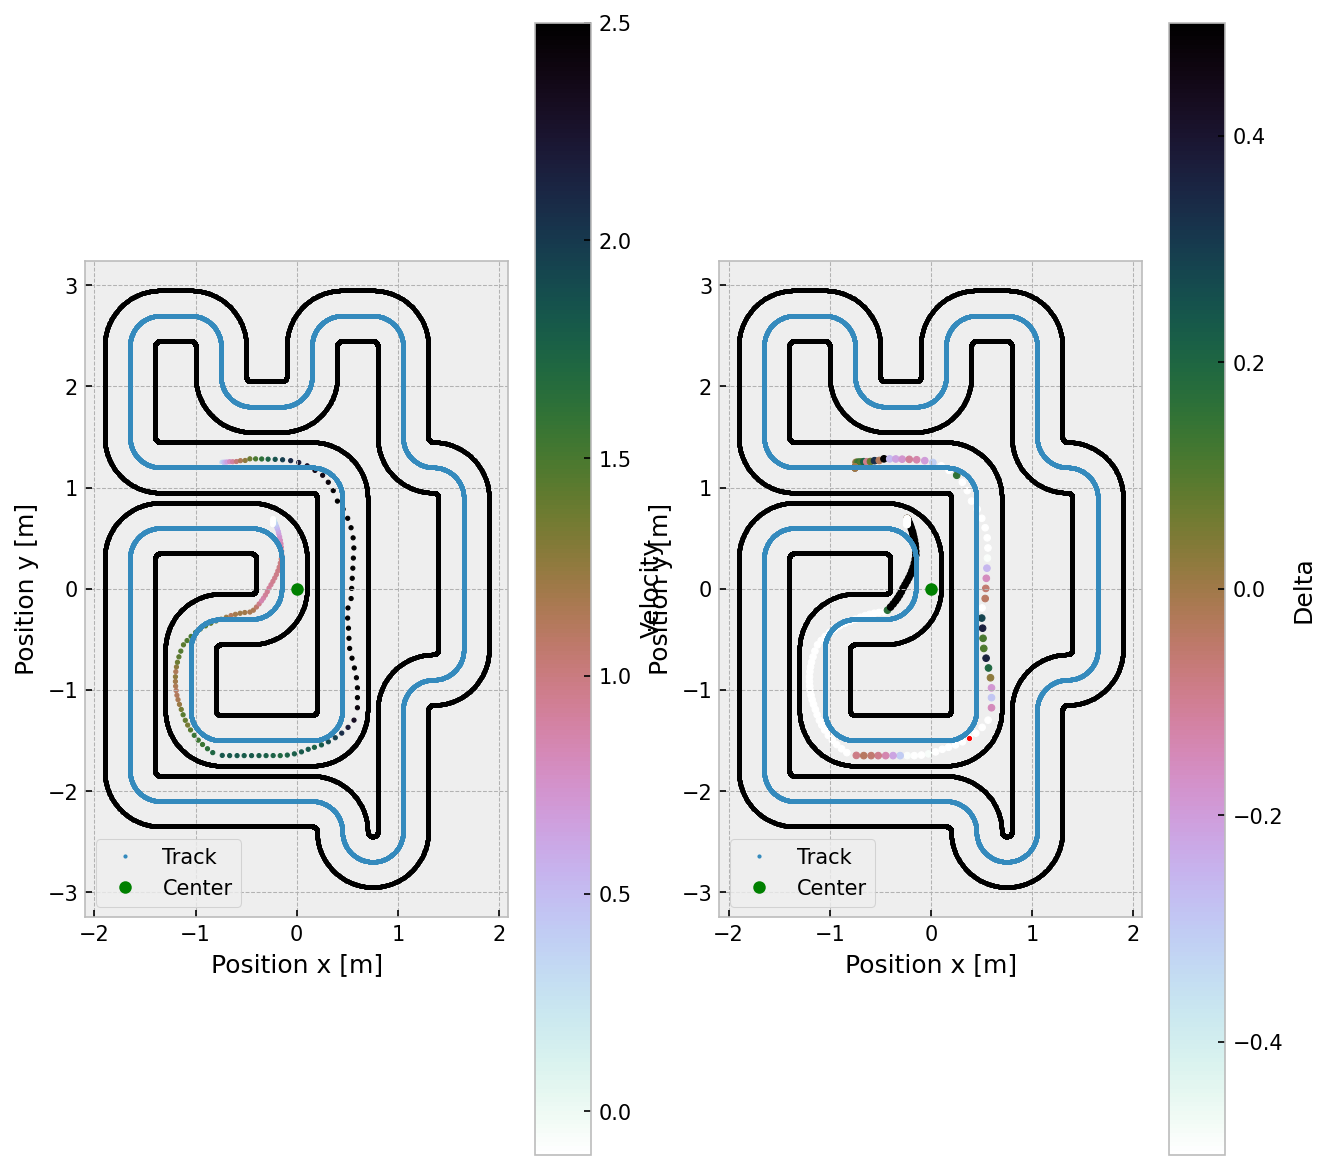

In [218]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

x_plot = np.array(x_list)
y_plot = np.array(y_list)

from matplotlib import cm

fig, axs = plt.subplots(1,2, figsize=(10,10), dpi=150)
gen.plotPoints(axs[0])
custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = axs[0].scatter(x_plot, y_plot, c=x_simulated[:,0,3], cmap=custom_cmap, s=4)
cbar1 = plt.colorbar(sct)
cbar1.set_label('Velocity') 

gen.plotPoints(axs[1])
custom_cmap2 = plt.get_cmap('cubehelix').reversed()
sct2 = axs[1].scatter(x_plot, y_plot, c=u_exec[:,1], cmap=custom_cmap2, s=10)
cbar2 = plt.colorbar(sct2)
cbar2.set_label('Delta') 

axs[1].scatter(x_plot[47], y_plot[47], c='red', s=4)

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

In [23]:
T = 30

x_sims = np.zeros((T,8))

In [24]:


x_in = np.array([ 8.362, -0.089, -0.558,  1.345,  8.362,  0.,     0.,     0.,   ])

In [25]:
u_test = np.array([[-0.1, 0.5]])
u_test = u_test.T.repeat(T,1).T

In [26]:
true_sim_dx.smooth_curve = 100

true_sim_dx.lr = 0.2
true_sim_dx.lr = 0.2

In [27]:
x_sims[0] = x_in
for t in range(1, len(x_sims)): 
    x_curr = true_sim_dx.forward(torch.tensor(x_sims[t-1]), torch.tensor(u_test[t-1]))
    x_sims[t] = x_curr

In [28]:
#x_sims[0] = x_in
#for t in range(1, len(x_sims)): 
#    x_curr = frenet_dynamics(torch.tensor(x_sims[t-1,:4]), torch.tensor(u_test[t-1]), track_coord, dt=0.04,L=0.2)
#    x_sims[t,:4] = x_curr

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


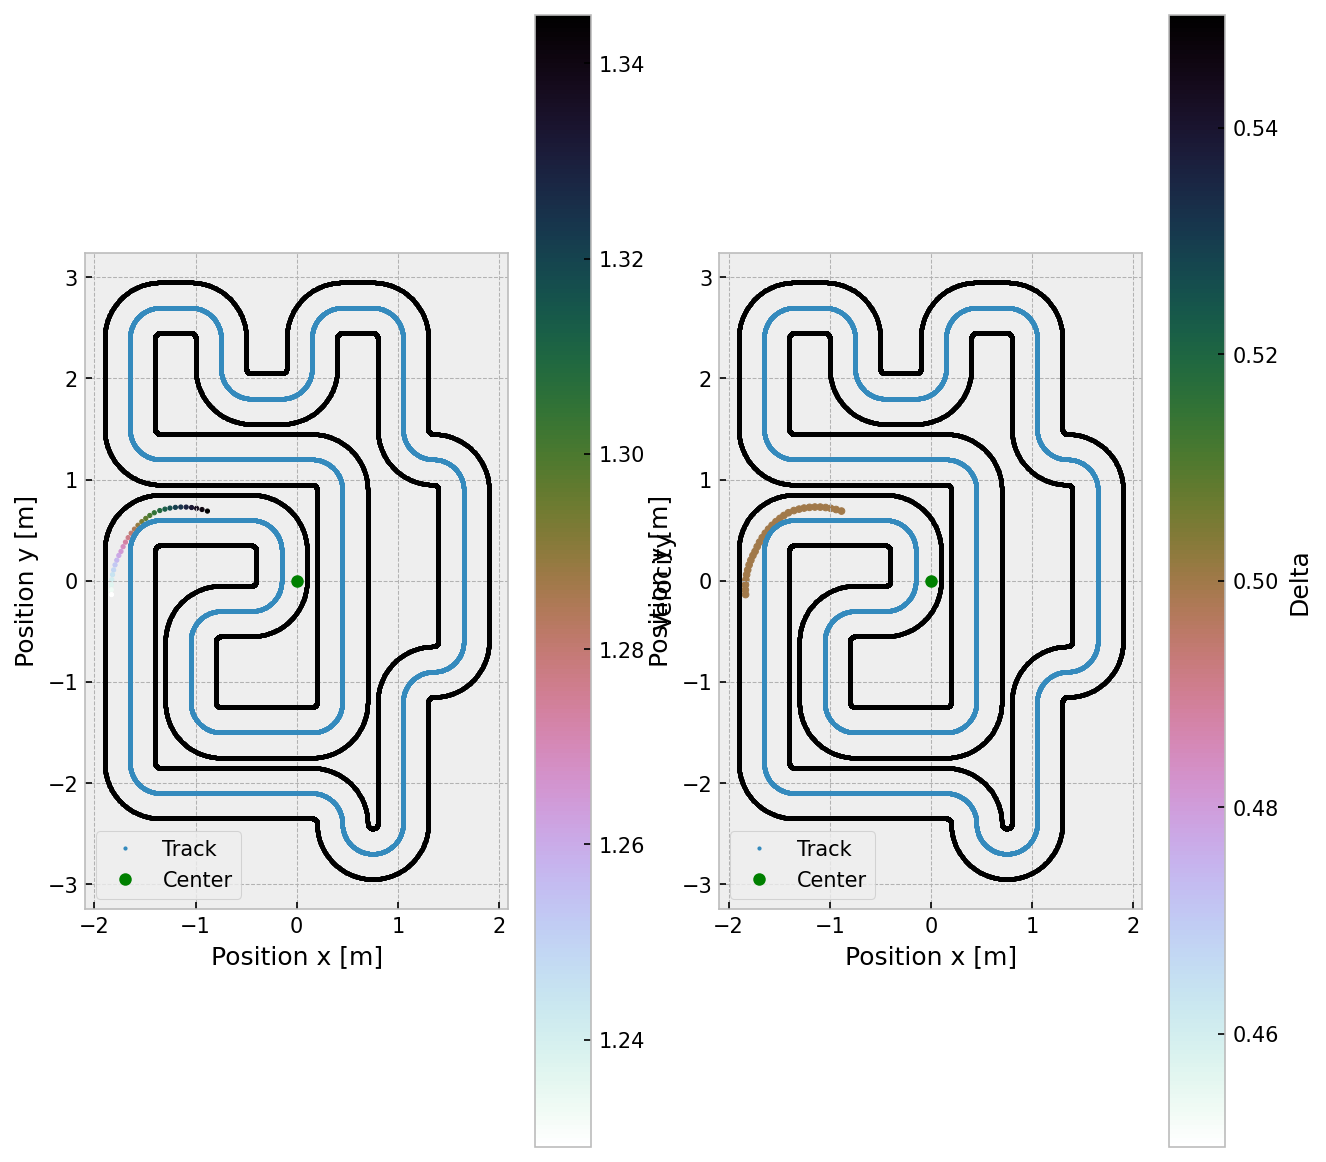

In [29]:
x_list = []
y_list = []

for i in range(x_sims.shape[0]):
    xy = frenet_to_cartesian(x_sims[i,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

x_plot = np.array(x_list)
y_plot = np.array(y_list)

from matplotlib import cm

fig, axs = plt.subplots(1,2, figsize=(10,10), dpi=150)
gen.plotPoints(axs[0])
custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = axs[0].scatter(x_plot, y_plot, c=x_sims[:,3], cmap=custom_cmap, s=4)
cbar1 = plt.colorbar(sct)
cbar1.set_label('Velocity') 

gen.plotPoints(axs[1])
custom_cmap2 = plt.get_cmap('cubehelix').reversed()
sct2 = axs[1].scatter(x_plot, y_plot, c=u_test[:,1], cmap=custom_cmap2, s=10)
cbar2 = plt.colorbar(sct2)
cbar2.set_label('Delta') 

#axs[1].scatter(x_plot[47], y_plot[47], c='red', s=4)

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

In [59]:
import torch




new_state = frenet_dynamics(state, control, track_coord, dt=0.04)
print(new_state)

tensor([1.6990, 0.1200, 0.1000, 2.0100], dtype=torch.float64)


In [49]:
track_coord

tensor([[-7.5000e-01, -7.4900e-01, -7.4800e-01,  ..., -4.5300e-01,
         -4.5200e-01, -4.5100e-01],
        [ 1.2000e+00,  1.2000e+00,  1.2000e+00,  ...,  1.2000e+00,
          1.2000e+00,  1.2000e+00],
        [ 0.0000e+00,  1.0011e-03,  2.0022e-03,  ...,  5.3732e+01,
          5.3733e+01,  5.3734e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.4493e-16,
         -2.4493e-16, -2.4493e-16],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], dtype=torch.float64)